In [1]:
import pandas as pd
import numpy as np

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

import matplotlib.pyplot as plt

2022-11-29 21:48:30.728866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 21:48:30.944471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 21:48:30.944496: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-29 21:48:32.221853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
import pandas as pd

In [3]:
data=pd.read_csv('english_hindi.csv')

In [4]:
train_data=data[:20000]

In [5]:
train_data.head()

,JANAMDIVAS,^जन्मदिवस$
0,RAKHA,^रक्खा$
1,MILIJULI,^मिलीजुली$
2,JAANCHON,^जांचों$
3,CHAMKATA,^चमकता$
4,KAYIYON,^कईयों$


In [6]:
input_words=train_data['JANAMDIVAS'].tolist()
target_words=train_data['^जन्मदिवस$'].tolist()

In [7]:
len(input_words),len(target_words)

(20000, 20000)

In [8]:
def build_vocab(input_words, target_words):
  input_vocab = set()
  target_vocab = set()
  for input_word, target_word in zip(input_words, target_words):
      input_vocab.update(set(input_word))
      target_vocab.update(set(target_word))
  return input_vocab, target_vocab

In [9]:
input_vocab, target_vocab = build_vocab(input_words, target_words)

In [10]:
input_vocab = sorted(list(input_vocab))
target_vocab = sorted(list(target_vocab))

In [11]:

input_token_index = dict([(char, i) for i, char in enumerate(input_vocab)])
target_token_index = dict([(char, i) for i, char in enumerate(target_vocab)])

In [12]:
num_encoder_tokens = len(input_vocab)
num_decoder_tokens = len(target_vocab)

In [13]:
max_encoder_seq_length = max([len(txt) for txt in input_words])
max_decoder_seq_length = max([len(txt) for txt in target_words])

In [14]:
print('Number of samples:', len(input_words))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 20000
Number of unique input tokens: 26
Number of unique output tokens: 63
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [15]:
encoder_input_data = np.zeros((len(input_words), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros( (len(input_words), max_decoder_seq_length, num_decoder_tokens), dtype='float32')


In [16]:
print(f"encoder input shape {encoder_input_data.shape}")
print(f"decoder input shape {decoder_input_data.shape}")
print(f"decoder target shape {decoder_target_data.shape}")

encoder input shape (20000, 20, 26)
decoder input shape (20000, 21, 63)
decoder target shape (20000, 21, 63)


In [17]:
for i, (input_text, target_text) in enumerate(zip(input_words, target_words)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.0
  # for the rest of sentence, mark it as space
  #encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

  for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, target_token_index[char]] = 1.0
    if t > 0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t-1, target_token_index[char]] = 1.0
      # for the rest of sentence, mark it as space
      #decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0

In [18]:
latent_dim = 256  # Latent dimensionality of the encoding space.
EMBEDDING_SIZE = 100

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
print(encoder_inputs.shape)

# Define embedding layer
encoder_embedding = tf.keras.layers.Embedding(num_encoder_tokens, EMBEDDING_SIZE, input_length=max_encoder_seq_length)
encoder_inputs_em = encoder_embedding(encoder_inputs)
print(encoder_inputs_em.shape)

# since embedding layer will add one more dim, we need to flatten last 2 dims
encoder_reshape = Reshape((-1, encoder_inputs_em.shape[2] * encoder_inputs_em.shape[3]))
encoder_inputs_re = encoder_reshape(encoder_inputs_em)
print(encoder_inputs_re.shape)

# Note that LSTM takes only 3 dims, (samples, timesteps, features)
encoder = LSTM(latent_dim, return_state=True)

encoder_outputs, state_h, state_c = encoder(encoder_inputs_re)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

(None, None, 26)


2022-11-29 21:48:49.957286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-29 21:48:49.957315: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-29 21:48:49.957339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sahitya-Inspiron-15-3567): /proc/driver/nvidia/version does not exist
2022-11-29 21:48:49.957609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(None, None, 26, 100)
(None, None, 2600)


In [19]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
print(decoder_inputs.shape)

# Define embeddling layer
decoder_embedding = tf.keras.layers.Embedding(num_decoder_tokens, latent_dim)
decoder_inputs_em = decoder_embedding(decoder_inputs)
print(decoder_inputs_em.shape)

# since embedding layer will add one more dim, we need to flatten last 2 dims
decoder_reshape = Reshape((-1, decoder_inputs_em.shape[2] * decoder_inputs_em.shape[3]))
decoder_inputs_re = decoder_reshape(decoder_inputs_em)
print(decoder_inputs_re.shape)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder = LSTM(latent_dim, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder(decoder_inputs_re, initial_state=encoder_states)
print(decoder_outputs.shape)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
print(decoder_outputs.shape)

(None, None, 63)
(None, None, 63, 256)
(None, None, 16128)
(None, None, 256)
(None, None, 63)


In [20]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 26)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 63)]   0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 26, 10  2600        ['input_1[0][0]']                
                                0)                                                                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 63, 25  16128       ['input_2[0][0]']            

In [21]:

# Training
batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
initial_learning_rate = 0.001

    # Add callbacks:
    # 'EarlyStopping' to stop training when the model is not enhancing anymore
    # 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model_cpu.h5"

model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate), 
        loss='categorical_crossentropy', 
        metrics=['accuracy'])

earlystopping_cb = EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=2,
        patience=5, 
        restore_best_weights=True)

mdlcheckpoint_cb = ModelCheckpoint(
        model_save_filename, 
        monitor="val_accuracy", 
        mode="max",
        verbose=1,
        save_best_only=True
    )

decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
        return lr * 1 / (1 + decay * epoch)
lrscheduler_cb = tf.keras.callbacks.LearningRateScheduler(lr_time_based_decay)


history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
              batch_size=batch_size, epochs=epochs,  validation_split=0.2, 
              callbacks=[earlystopping_cb, mdlcheckpoint_cb, lrscheduler_cb])

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 1.2661 - accuracy: 0.6843
Epoch 1: val_accuracy improved from -inf to 0.69514, saving model to model_cpu.h5
250/250 [==============================] - 904s 4s/step - loss: 1.2661 - accuracy: 0.6843 - val_loss: 1.2591 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 1.2487 - accuracy: 0.6946
Epoch 2: val_accuracy did not improve from 0.69514
250/250 [==============================] - 892s 4s/step - loss: 1.2487 - accuracy: 0.6946 - val_loss: 1.2585 - val_accuracy: 0.6930 - lr: 9.9990e-04
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 1.2463 - accuracy: 0.6963
Epoch 3: val_accuracy did not improve from 0.69514
250/250 [==============================] - 906s 4s/step - loss: 1.2463 - accuracy: 0.6963 - val_loss: 1.2582 - val_accuracy: 0.6927 - lr: 9.9970e-04
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 1.2451 - accura

In [22]:
# list all data in histo
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


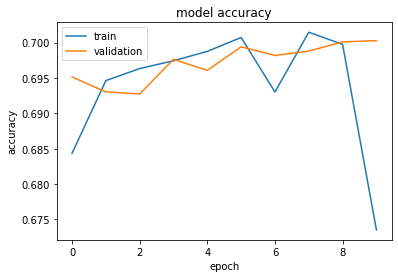

In [23]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

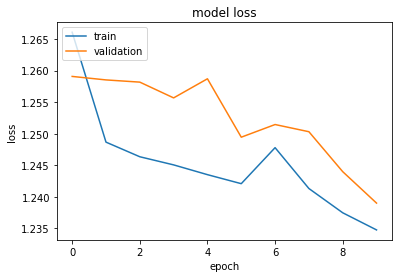

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
# Restore the model and construct the encoder and decoder.
model = load_model('model_cpu.h5')
# model = load_model("model_v1.h5")

In [26]:
# Predictions
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[6].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_inputs_em = decoder_embedding(decoder_inputs)

# since embedding layer will add one more dim, we need to flatten last 2 dims
decoder_reshape = Reshape((-1, decoder_inputs_em.shape[2] * decoder_inputs_em.shape[3]))
decoder_inputs_re = decoder_reshape(decoder_inputs_em)
print(decoder_inputs_re.shape)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[7] # lstm_2
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs_re, initial_state=decoder_states_inputs
)

decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[-1]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

(None, None, 16128)


In [27]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [28]:
def predict_target(input_string):
  # convert for encoding 
  input_data = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
  for t, char in enumerate(input_string):
    input_data[0, t, input_token_index[char]] = 1.

  # Encode the input as state vectors.
  states_value = encoder_model(input_data)

   # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1, num_decoder_tokens), dtype='float32')
  # Populate the first character of target sequence with the start character.
  target_seq[0, 0, target_token_index['^']] = 1.0

  stop_condition = False
  decoded_sentence = ""

  while True:
    output_tokens, d_h, d_c = decoder_model.predict([target_seq] + states_value)
    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]

    # Exit condition: either hit max length
    # or find stop character.
    if sampled_char == "$" or len(decoded_sentence) > max_decoder_seq_length:
      break
      
    decoded_sentence += sampled_char

    # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.0

    # Update states
    states_value = [d_h, d_c]
  return decoded_sentence

In [33]:
test_input = 'X'
predicted_string = predict_target(test_input)
predicted_string

1/1 [==============================] - 0s 45ms/step


'प्र्रा'